※ 상점 및 제품의 목록의 매월 약간 변경이 됨 -> 이를 처리할 수 있는 강력한 모델 구축
※ target value = 0~20으로 clip

#### data Description
 + sales_train (2935849, 6)  
    + date: 일 데이터(2013년 1월 ~ 2015년 10월)  
    + date_block_num: 연속 월 숫자(34: 1~33)
    + shop_id: 상점의 고유 식별자(60: 0~59)
    + item_id: 제품의 고유 식별자
    + item_price: 항목의 현재 가격
    + item_cnt_day: 판매된 제품 수
 + test &submission (214200, 4)
    + ID
    + shop_id: 상점의 고유 식별자(0~59)
    + item_id: 제품의 고유 식별자  
    + item_cnt_month:  

추가정보
 + cate (22170, 2)
    + item_category_name: 항목 범주의 이름
    + item_category_id: 항목 카테고리의 고유 식별자
 + items (84, 2)
    + item_name: 항목의 이름
    + item_id: 제품의 고유 식별자
    + item_category_id: 항목 카테고리의 고유 식별자
 + shops (60, 2)
    + shop_name: 가게이름(60개)
    + shop_id: 상점의 고유 식별자(0~59)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## datasets

In [2]:
train = pd.read_csv("data/sales_train.csv", encoding="utf-8")
test = pd.read_csv("data/test.csv", encoding="utf-8")
sub = pd.read_csv("data/sample_submission.csv", encoding="utf-8")

cats = pd.read_csv("data/item_categories.csv", encoding="utf-8")
items = pd.read_csv("data/items.csv", encoding="utf-8")
shops = pd.read_csv("data/shops.csv", encoding="utf-8")

## EDA

In [3]:
df = [train, test, sub, cats, items, shops]
dname = ["train", "test", "sub", "cats", "items", "shops"]

for i in range(len(df)):
    print("data: ", dname[i], "\n",
          "shape", df[i].shape, "\n"
          "Nan: ", list(df[i].isnull().sum()), "\n",
          df[i].head())
    
# 결측값 없음

data:  train 
 shape (2935849, 6) 
Nan:  [0, 0, 0, 0, 0, 0] 
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
data:  test 
 shape (214200, 3) 
Nan:  [0, 0, 0] 
    ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
data:  sub 
 shape (214200, 2) 
Nan:  [0, 0] 
    ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5
data:  cats 
 shape (84, 2) 
Nan:  [0, 0] 
         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники     

## train

<AxesSubplot:>

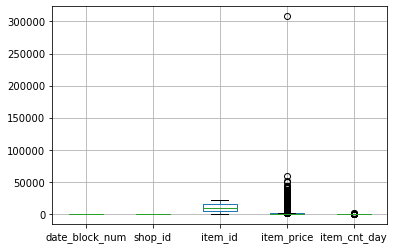

In [4]:
train.boxplot()

In [5]:
# item_price 307980 루블이상 데이터(1개) 존재
train[train["item_price"]  > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [6]:
# item_price 1보다 작은 값(1개) 존재
train[train["item_price"] <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


<AxesSubplot:>

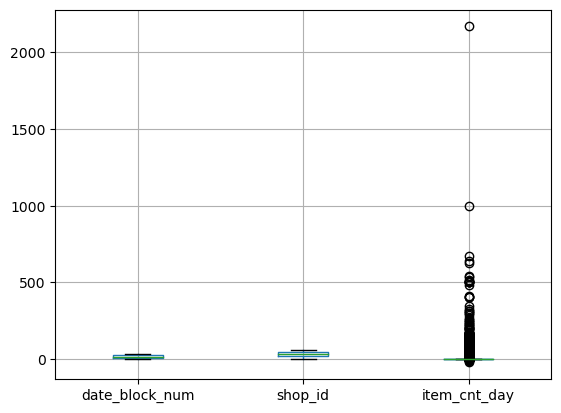

In [7]:
train.drop(["item_price", "item_id"], axis=1).boxplot()

In [8]:
train[train["item_cnt_day"] < 0] # 판매개수 0보다 작은 값(7356개) 존재

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [9]:
train[train["item_cnt_day"] > 1000] # 판매개수 1000보다 큰 값(1개) 존재

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [10]:
train["day"] = train["date"].str.split(".").str.get(0)
train["month"] = train["date"].str.split(".").str.get(1)
train["year"] = train["date"].str.split(".").str.get(2)

In [11]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
2935844,10.10.2015,33,25,7409,299.0,1.0,10,10,2015
2935845,09.10.2015,33,25,7460,299.0,1.0,09,10,2015
2935846,14.10.2015,33,25,7459,349.0,1.0,14,10,2015
2935847,22.10.2015,33,25,7440,299.0,1.0,22,10,2015
2935848,03.10.2015,33,25,7460,299.0,1.0,03,10,2015


In [12]:
# 중복값 6개 존재
train.duplicated().sum()
train[train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
76962,05.01.2013,0,54,20130,149.0,1.0,05,01,2013
1435367,23.02.2014,13,50,3423,999.0,1.0,23,02,2014
1496766,23.03.2014,14,21,3423,999.0,1.0,23,03,2014
1671873,01.05.2014,16,50,3423,999.0,1.0,01,05,2014
1866340,12.07.2014,18,25,3423,999.0,1.0,12,07,2014
2198566,31.12.2014,23,42,21619,499.0,1.0,31,12,2014


In [13]:
# 이상치 및 중복값 remove후 성능평가 후 다시 고려

[]

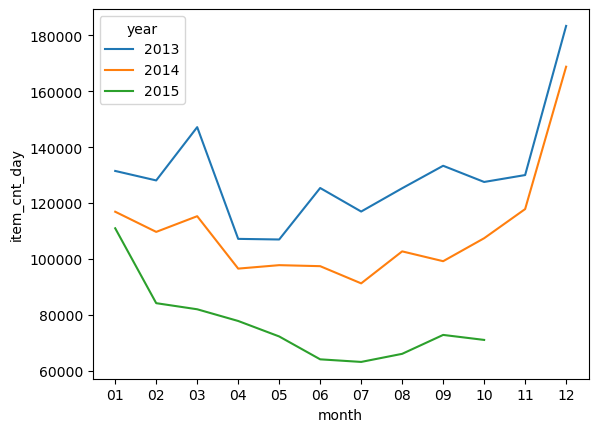

In [14]:
# 년도_월별 판매건수
y_m_count = train.groupby(["year", "month"])["item_cnt_day"].sum().to_frame().reset_index()
sns.lineplot(x = "month",
             y = "item_cnt_day",
             data = y_m_count,
             hue = "year")
plt.plot()

[]

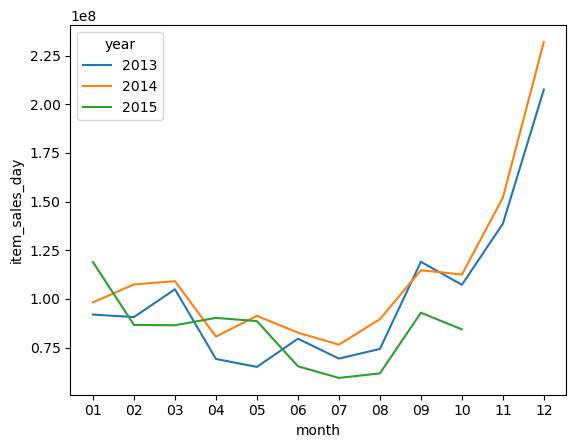

In [15]:
# 년도_월별 매출
train["item_sales_day"] = train["item_cnt_day"] * train["item_price"]
y_m_count = train.groupby(["year", "month"])["item_sales_day"].sum().to_frame().reset_index()
sns.lineplot(x = "month",
             y = "item_sales_day",
             data = y_m_count,
             hue = "year")
plt.plot()

## test

In [16]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [17]:
print(len(set(train["item_id"])))   # train의 아이템 종류 21807
print(len(set(test["item_id"])))    # test의 아이템 종류 5100

# train - test: train에만 판매정보가 있는 아이템 종류 17070
print(len(set(train["item_id"]) - set(test["item_id"])))

# test - train: train에는 판매정보가 없는 test의 아이템 종류 363
print(len(set(test["item_id"]) - set(train["item_id"])))

# train에 있는 아이템종류가 test에도 있는 경우: 4737
print(len(set(test["item_id"]) & set(train["item_id"])))

21807
5100
17070
363
4737


## item_category_name

In [18]:
cats["item_category_name"]

0       PC - Гарнитуры/Наушники
1              Аксессуары - PS2
2              Аксессуары - PS3
3              Аксессуары - PS4
4              Аксессуары - PSP
                ...            
79                    Служебные
80           Служебные - Билеты
81      Чистые носители (шпиль)
82    Чистые носители (штучные)
83             Элементы питания
Name: item_category_name, Length: 84, dtype: object

In [19]:
cats["cats_main"]=cats['item_category_name'].str.split(" - ").apply(lambda x: x[0])
cats["cats_sub"]=cats['item_category_name'].str.split(" - ").apply(lambda x: x[1] if len(x)>1 else x[0])

In [20]:
cats["cats_main"].value_counts()

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Музыка                                6
Программы                             6
Кино                                  5
Карты оплаты                          4
Игры PC                               4
Служебные                             2
Чистые носители (штучные)             1
Чистые носители (шпиль)               1
PC                                    1
Карты оплаты (Кино, Музыка, Игры)     1
Игры MAC                              1
Игры Android                          1
Доставка товара                       1
Билеты (Цифра)                        1
Элементы питания                      1
Name: cats_main, dtype: int64

In [21]:
cats["cats_sub"].value_counts()

Цифра                        4
PS3                          3
PS4                          3
PSP                          3
PSVita                       3
                            ..
Комиксы, манга               1
Компьютерная литература      1
Открытки                     1
Познавательная литература    1
Элементы питания             1
Name: cats_sub, Length: 67, dtype: int64

In [22]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

le.fit(cats["cats_main"])
cats["cats_main_id"]=le.transform(cats["cats_main"])

le.fit(list(cats["cats_sub"]))
cats["cats_sub_id"]=le.transform(cats["cats_sub"])

## shops

In [23]:
shops
print(shops.shape)
print(shops.info())
shops.head()

(60, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [24]:
# 상점이름 변경
shops.loc[shops["shop_name"] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [25]:
# city 정보 추출
# shops['shop_name'].str.split(' ').str.get(0)
shops["city_name"] = shops['shop_name'].str.split(' ').apply(lambda x: x[0])
shops["city_name"].value_counts()[:5]

Москва          13
Тюмень           3
Воронеж          3
РостовНаДону     3
!Якутск          2
Name: city_name, dtype: int64

In [26]:
# 도시이름 대치
shops[shops["city_name"] == "!Якутск"]
shops.loc[shops["city_name"] == "!Якутск", "city_name"] = "Якутск"

In [27]:
# 대치확인
shops[shops["city_name"] == "!Якутск"]

,shop_name,shop_id,city,city_name


In [28]:
# 확인
shops["city_name"].value_counts()[:10]

Москва          13
Якутск           4
РостовНаДону     3
Воронеж          3
Тюмень           3
Новосибирск      2
Н.Новгород       2
Самара           2
Красноярск       2
Казань           2
Name: city_name, dtype: int64

In [29]:
# label encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(shops["city_name"])
shops["city_id"]=le.transform(shops["city_name"])

In [30]:
shops["city_id"].value_counts()[:5]

13    13
29     4
18     3
4      3
24     3
Name: city_id, dtype: int64

In [31]:
shops[:10]

,shop_name,shop_id,city,city_name,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,Волжский,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,Вологда,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,Воронеж,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,Воронеж,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,Воронеж,4
9,Выездная Торговля,9,Выездная,Выездная,5


In [32]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62
